In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import ParameterGrid
from itertools import product

# Define your custom style
custom_style = {
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'gray',
    'axes.grid': True,
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'axes.labelcolor': 'black',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'font.size': 12,
    'legend.frameon': True,
    'legend.facecolor': 'white',
    'legend.edgecolor': 'gray',
    'legend.fontsize': 10,
    'legend.loc': 'best',
    'figure.autolayout': True  # Adjust layout to avoid clipping
}

# Update the default rc settings
plt.rcParams.update(custom_style)

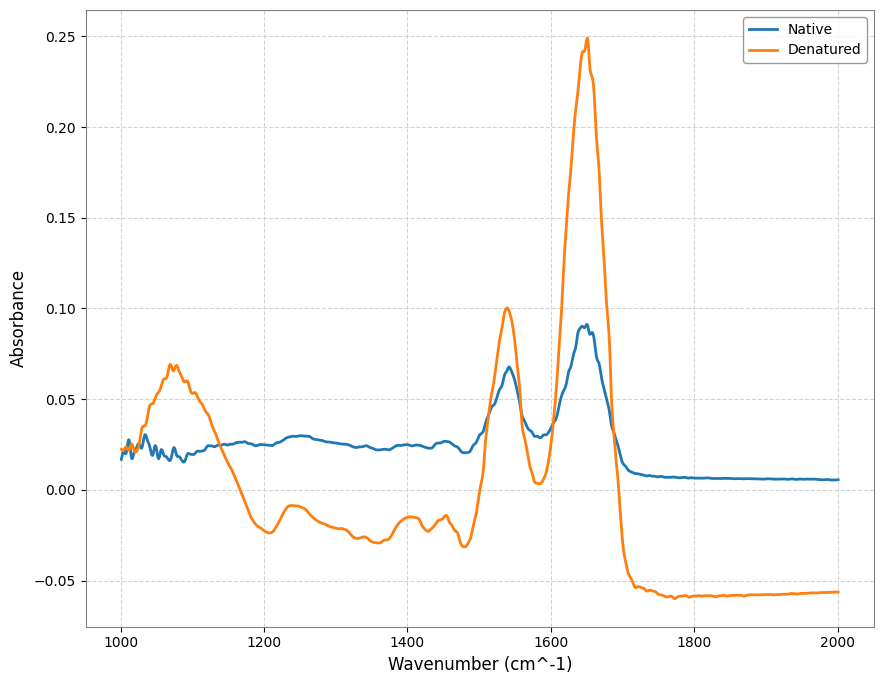

In [2]:
data_native = pd.read_excel('../../data/lisozima_nativo_data.xlsx')
data_denatured = pd.read_excel('../../data/lisozima_denaturato_data.xlsx')

# Remove frist trhee rows
data_native = data_native.iloc[3:]
data_denatured = data_denatured.iloc[3:]

# Remove all rows after the 1039th
data_native = data_native.iloc[:1039]
data_denatured = data_denatured.iloc[:1039]

# Add columns names
data_native.columns = ['Wavenumber (cm^-1)', 'Absorbance (AU)']
data_denatured.columns = ['Wavenumber (cm^-1)', 'Absorbance (AU)']

# Plot the data
plt.figure(figsize=(9, 7))
plt.plot(data_native['Wavenumber (cm^-1)'], data_native['Absorbance (AU)'], label='Native')
plt.plot(data_denatured['Wavenumber (cm^-1)'], data_denatured['Absorbance (AU)'], label='Denatured')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance')
plt.legend()

### Make the cuts for the two Amine peaks

In [3]:
# Take the Amine I peak (1600-1700 cm^-1)
data_amine_I_native = data_native[(data_native['Wavenumber (cm^-1)'] > 1600) & (data_native['Wavenumber (cm^-1)'] < 1700)]
data_amine_I_denatured = data_denatured[(data_denatured['Wavenumber (cm^-1)'] > 1600) & (data_denatured['Wavenumber (cm^-1)'] < 1700)]

# Take the Amine II peak (1510-1580 cm^-1)
data_amine_II_native = data_native[(data_native['Wavenumber (cm^-1)'] > 1510) & (data_native['Wavenumber (cm^-1)'] < 1580)]
data_amine_II_denatured = data_denatured[(data_denatured['Wavenumber (cm^-1)'] > 1510) & (data_denatured['Wavenumber (cm^-1)'] < 1580)]


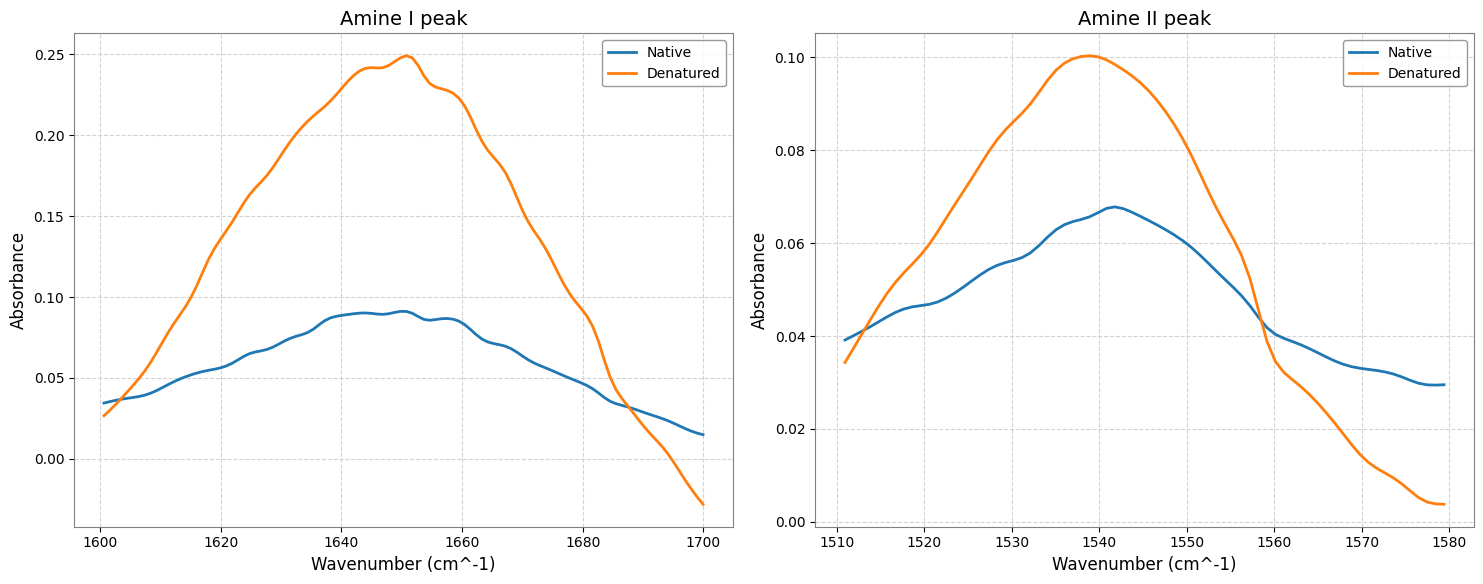

In [4]:
# Plot the Amine I peak and Amine II peak in two side by side subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(data_amine_I_native['Wavenumber (cm^-1)'], data_amine_I_native['Absorbance (AU)'], label='Native')
axs[0].plot(data_amine_I_denatured['Wavenumber (cm^-1)'], data_amine_I_denatured['Absorbance (AU)'], label='Denatured')
axs[0].set_title('Amine I peak')
axs[0].set_xlabel('Wavenumber (cm^-1)')
axs[0].set_ylabel('Absorbance')
axs[0].legend()

axs[1].plot(data_amine_II_native['Wavenumber (cm^-1)'], data_amine_II_native['Absorbance (AU)'], label='Native')
axs[1].plot(data_amine_II_denatured['Wavenumber (cm^-1)'], data_amine_II_denatured['Absorbance (AU)'], label='Denatured')
axs[1].set_title('Amine II peak')
axs[1].set_xlabel('Wavenumber (cm^-1)')
axs[1].set_ylabel('Absorbance')
axs[1].legend()

# Amine I theoretical peaks
amine_I_teo_peaks = [1652, 1629, 1696, 1640, 1680, 1656]
# Amine II theoretical peaks
amine_II_teo_peaks = [1548, 1530, 1540, 1535]

# Add vertical dotted lines for the theoretical peaks
#for peak in amine_I_teo_peaks:
#    axs[0].axvline(peak, color='gray', linestyle='--')
#
#for peak in amine_II_teo_peaks:
#    axs[1].axvline(peak, color='gray', linestyle='--')

### Multi gaussian fit

In [5]:
# Define the multi-Gaussian model function
def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    # covnert x to numpy array of float64
    x = np.float64(x)
    for i in range(0, len(params), 3):
        amplitude = np.float64(params[i])
        mean = np.float64(params[i+1])
        sigma = np.float64(params[i+2])
        y += amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))
    # convert y to numpy array of float64
    y = np.float64(y)
    return y

# Function to perform the fitting
def fit_multi_gaussian(x_data, y_data, initial_params):
    popt, pcov = curve_fit(multi_gaussian, x_data, y_data, p0=initial_params)
    return popt, pcov

def multi_gaussian_with_fixed_means(x, *params):
    teoretical_peaks = [1652, 1629, 1696, 1640, 1680, 1656]
    y = np.zeros_like(x)
    # covnert x to numpy array of float64
    x = np.float64(x)
    for i in range(0, len(params), 2):
        amplitude = np.float64(params[i])
        sigma = np.float64(params[i+1])
        y += amplitude * np.exp(-((x - teoretical_peaks[i/2]) ** 2) / (2 * sigma ** 2))
    # convert y to numpy array of float64
    y = np.float64(y)
    return y

def fit_multi_gaussian_with_fixed_means(x_data, y_data, initial_params):
    popt, pcov = curve_fit(multi_gaussian_with_fixed_means, x_data, y_data, p0=initial_params)
    return popt, pcov

In [6]:
# Initial parameters for the multi-Gaussian model
                        # Amplitude, Mean, Sigma
amine_I_initial_params = [0.1, 1652, 10,  # Alpha helix
                          0.05, 1629, 10, # Beta sheet anti-parallel
                          0.05, 1696, 10, # Beta sheet anti-parallel
                          0.07, 1640, 10, # Beta sheet parallel
                          0.06, 1680, 10, # Turn
                          0.07, 1656, 10] # Random coil

amine_I_components = ['Alpha helix', 'Beta sheet anti-parallel', 'Beta sheet anti-parallel', 'Beta sheet parallel', 'Turn', 'Random coil', 'additional 1', 'additional 2']

amine_II_initial_params = [0.04, 1548, 10,  # Alpha helix
                           0.08, 1530, 10, # Beta sheet anti-parallel
                           0.08, 1540, 10, # Beta sheet parallel
                           0.04, 1535, 10] # Random coil

### single fit

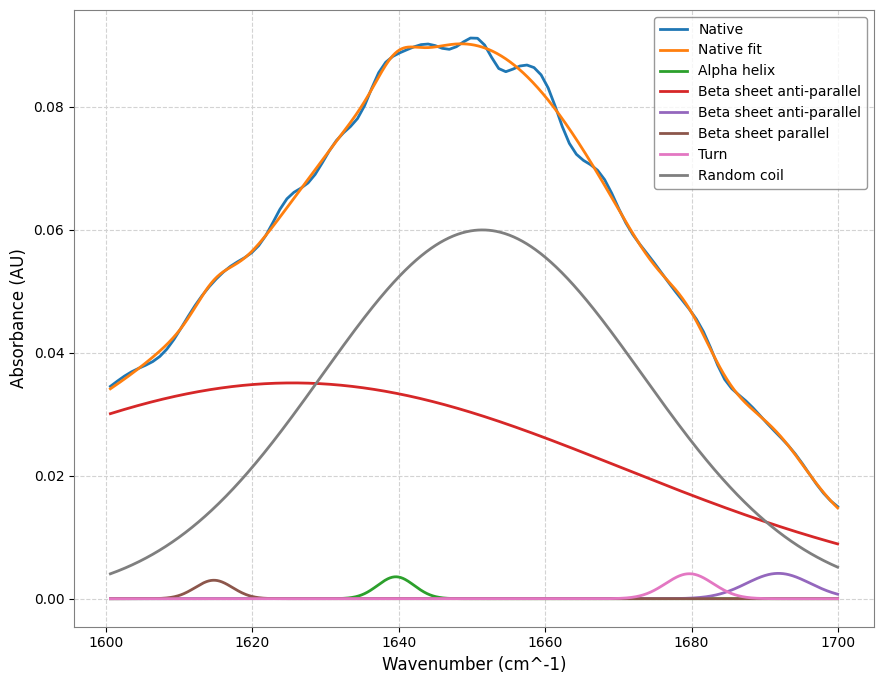

In [36]:
# Fit the Amine I peak (native)
popt_amine_I_native, pcov_amine_I_native = fit_multi_gaussian(data_amine_I_native['Wavenumber (cm^-1)'], data_amine_I_native['Absorbance (AU)'], amine_I_initial_params)

# Fit the Amine I peak (denatured)
#popt_amine_I_denatured, pcov_amine_I_denatured = fit_multi_gaussian(data_amine_I_denatured['Wavenumber (cm^-1)'], data_amine_I_denatured['Absorbance (AU)'], amine_I_initial_params)

# Plot the results
plt.figure(figsize=(9, 7))
plt.plot(data_amine_I_native['Wavenumber (cm^-1)'], data_amine_I_native['Absorbance (AU)'], label='Native')
amine_I_linespace = np.linspace(data_amine_I_native['Wavenumber (cm^-1)'].min(), data_amine_I_native['Wavenumber (cm^-1)'].max(), 1000)
plt.plot(amine_I_linespace, multi_gaussian(amine_I_linespace, *popt_amine_I_native), label='Native fit')
#Plot the individual components (gaussians)
for i in range(0, len(popt_amine_I_native), 3):
    plt.plot(amine_I_linespace, popt_amine_I_native[i] * np.exp(-((amine_I_linespace - popt_amine_I_native[i+1]) ** 2) / (2 * popt_amine_I_native[i+2] ** 2)), label=amine_I_components[i//3])
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance (AU)')
plt.legend()

In [39]:
# Check the central values of the components and compare with the initial values
# make a table with: component, initial mean, fitted mean
amine_I_components_table = pd.DataFrame(columns=['Component', 'Initial mean', 'Fitted mean'])
for i in range(0, len(popt_amine_I_native), 3):
    amine_I_components_table = pd.concat([amine_I_components_table, pd.DataFrame({'Component': [amine_I_components[i//3]], 'Initial mean': [amine_I_initial_params[i+1]], 'Fitted mean': [popt_amine_I_native[i+1]]})], ignore_index=True)

amine_I_components_table.head()


C:\Users\giova\AppData\Local\Temp\ipykernel_17212\4159475389.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  amine_I_components_table = pd.concat([amine_I_components_table, pd.DataFrame({'Component': [amine_I_components[i//3]], 'Initial mean': [amine_I_initial_params[i+1]], 'Fitted mean': [popt_amine_I_native[i+1]]})], ignore_index=True)


,Component,Initial mean,Fitted mean
0,Alpha helix,1652,1639.611319
1,Beta sheet anti-parallel,1629,1625.543126
2,Beta sheet anti-parallel,1696,1691.850232
3,Beta sheet parallel,1640,1614.754837
4,Turn,1680,1679.691547


### Multiple fit

In [33]:
# Intial parameters for grid search mode
# Define the mean parameters and the ranges for Amplitude and Sigma
mean_params_I = [1652, 1629, 1696, 1640, 1680, 1656, 1670, 1615]  # Mean values
sigmas_I = np.linspace(1, 15, 20) # Sigma range
amine_I_components = ['Alpha helix', 'Beta sheet anti-parallel', 'Beta sheet anti-parallel', 'Beta sheet parallel', 'Turn', 'Random coil', 'additional 1', 'additional 2']

# Finding possible amplitudes
amplitudes_I = []
correction_factor = 0.9
for mean in mean_params_I:
    # evaluate the data where the mean is located
    data_mean_index = data_amine_I_native['Wavenumber (cm^-1)'].sub(mean).abs().idxmin()
    # get the amplitude of the data at the mean
    amplitude = data_amine_I_native['Absorbance (AU)'][data_mean_index]
    # correct the amplitude and append it to the list
    amplitudes_I.append(amplitude * correction_factor)

# Create the grid of parameters
param_I_grid = []
for sigma in sigmas_I:
    params = []
    for i,amplitude in enumerate(amplitudes_I):
        params.append(amplitude)
        params.append(mean_params_I[i])
        params.append(sigma)
    param_I_grid.append(params)

In [34]:
# Load your data for Peak I
x_data_I = data_amine_I_native['Wavenumber (cm^-1)']
y_data_I = data_amine_I_native['Absorbance (AU)']

best_mse = float('inf')
best_fit_cov_I = None
# Perform the grid search for Peak I
for init_params_I in param_I_grid:
    try:
        fit_I_params, pcov_amine_I_native = fit_multi_gaussian(x_data_I, y_data_I, init_params_I)
    except:
        continue
    residuals_I = y_data_I - multi_gaussian(x_data_I, *fit_I_params)
    mse_I = np.mean(residuals_I**2)
    if mse_I < best_mse:
        best_mse = mse_I
        best_fit_params_I = fit_I_params
        best_fit_cov_I = pcov_amine_I_native


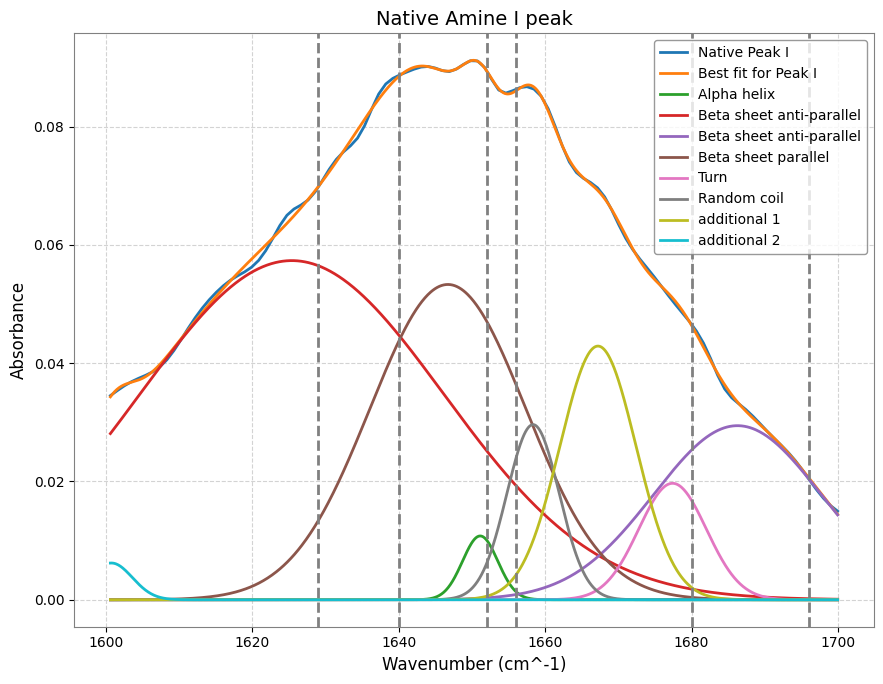

In [35]:
# Plot the results for Peak I
plt.figure(figsize=(9, 7))
plt.plot(x_data_I, y_data_I, label='Native Peak I')
amine_I_linespace = np.linspace(x_data_I.min(), x_data_I.max(), 1000)
plt.plot(amine_I_linespace, multi_gaussian(amine_I_linespace, *best_fit_params_I), label='Best fit for Peak I')
# Plot the individual components (gaussians)
for i in range(0, len(best_fit_params_I), 3):
    plt.plot(amine_I_linespace, best_fit_params_I[i] * np.exp(-((amine_I_linespace - best_fit_params_I[i+1]) ** 2) / (2 * best_fit_params_I[i+2] ** 2)), label=amine_I_components[i//3])

# Add vertical dotted lines for the theoretical peaks
for peak in amine_I_teo_peaks:
    plt.axvline(peak, color='gray', linestyle='--')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance')
plt.title('Native Amine I peak')
plt.legend()
plt.show()

In [39]:
# put the parameters in a table
amine_I_components_table = pd.DataFrame(columns=['Media', 'Errore Media', 'sigma', 'Errore Sigma', 'ampiezza', 'Errore Ampiezza'])
for i in range(0, len(best_fit_params_I), 3):
    amine_I_components_table = pd.concat([amine_I_components_table, pd.DataFrame({'Media': [best_fit_params_I[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_I[i+1][i+1])], 'sigma': [best_fit_params_I[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_I[i+2][i+2])], 'ampiezza': [best_fit_params_I[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_I[i][i])]})], ignore_index=True)

amine_I_components_table.head(10)

C:\Users\giova\AppData\Local\Temp\ipykernel_33608\3302747789.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  amine_I_components_table = pd.concat([amine_I_components_table, pd.DataFrame({'Media': [best_fit_params_I[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_I[i+1][i+1])], 'sigma': [best_fit_params_I[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_I[i+2][i+2])], 'ampiezza': [best_fit_params_I[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_I[i][i])]})], ignore_index=True)


,Media,Errore Media,sigma,Errore Sigma,ampiezza,Errore Ampiezza
0,1651.128735,0.354430,2.404463,0.323555,0.010789,0.002779
1,1625.406714,6.995469,20.744657,5.060357,0.057342,0.007307
2,1686.262285,2.875205,11.408259,1.763278,0.029432,0.003432
3,1646.717172,0.929931,10.642487,1.835323,0.053306,0.025315
4,1677.398229,2.428436,4.620562,1.303438,0.019689,0.016203
5,1658.351830,0.646918,3.573503,0.576959,0.029611,0.012243
6,1667.212575,0.545832,5.193415,1.926007,0.042891,0.006241
7,1600.774915,0.933252,2.841880,0.903945,0.006210,0.002151


In [41]:
# Get initial amplitudes for amine I denatured
amplitudes_I_denatured = []
for mean in mean_params_I:
    # evaluate the data where the mean is located
    data_mean_index = data_amine_I_denatured['Wavenumber (cm^-1)'].sub(mean).abs().idxmin()
    # get the amplitude of the data at the mean
    amplitude = data_amine_I_denatured['Absorbance (AU)'][data_mean_index]
    # correct the amplitude and append it to the list
    amplitudes_I_denatured.append(amplitude * correction_factor)

# Create the grid of parameters for denatured
param_I_grid_denatured = []
for sigma in sigmas_I:
    params = []
    for i,amplitude in enumerate(amplitudes_I_denatured):
        params.append(amplitude)
        params.append(mean_params_I[i])
        params.append(sigma)
    param_I_grid_denatured.append(params)


In [42]:
# Fit the denatured Amine I peak

X_den_I = data_amine_I_denatured['Wavenumber (cm^-1)']
Y_den_I = data_amine_I_denatured['Absorbance (AU)']

best_mse = float('inf')
best_fit_cov_den_I = None
# Perform the grid search for Peak I
for init_params_I in param_I_grid_denatured:
    try:
        fit_I_params, pcov_amine_I_denaturated = fit_multi_gaussian(X_den_I, Y_den_I, init_params_I)
    except:
        continue
    residuals_I = Y_den_I - multi_gaussian(X_den_I, *fit_I_params)
    mse_I = np.mean(residuals_I**2)
    if mse_I < best_mse:
        best_mse = mse_I
        best_fit_params_den_I = fit_I_params
        best_fit_cov_den_I = pcov_amine_I_denaturated


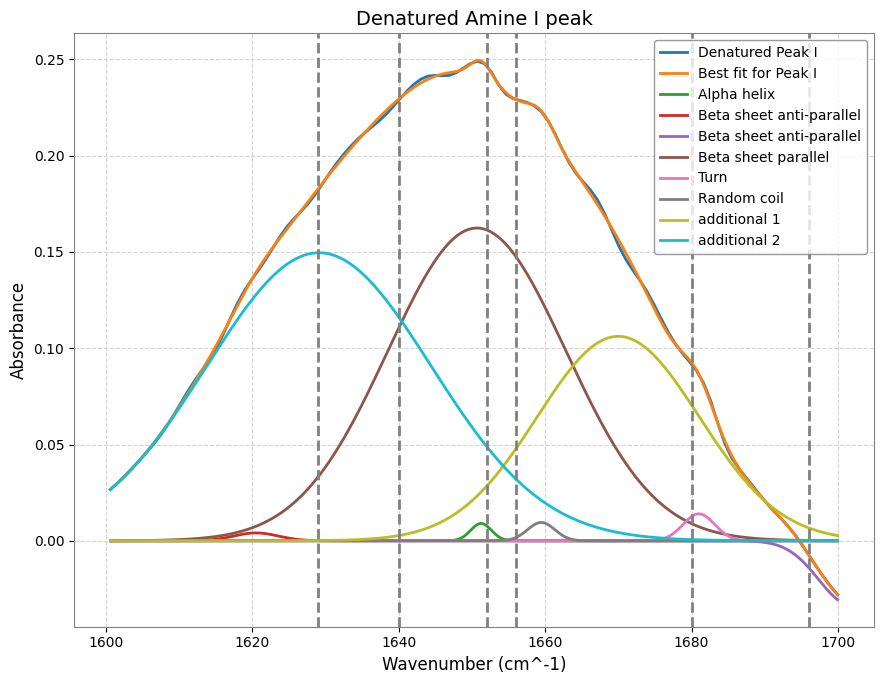

In [43]:
# Plot the results for Peak I
plt.figure(figsize=(9, 7))
plt.plot(X_den_I, Y_den_I, label='Denatured Peak I')
amine_I_linespace = np.linspace(X_den_I.min(), X_den_I.max(), 1000)
plt.plot(amine_I_linespace, multi_gaussian(amine_I_linespace, *best_fit_params_den_I), label='Best fit for Peak I')
# Plot the individual components (gaussians)
for i in range(0, len(best_fit_params_den_I), 3):
    plt.plot(amine_I_linespace, best_fit_params_den_I[i] * np.exp(-((amine_I_linespace - best_fit_params_den_I[i+1]) ** 2) / (2 * best_fit_params_den_I[i+2] ** 2)), label=amine_I_components[i//3])

# Add vertical dotted lines for the theoretical peaks
for peak in amine_I_teo_peaks:
    plt.axvline(peak, color='gray', linestyle='--')

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance')
plt.title('Denatured Amine I peak')
plt.legend()
plt.show()

In [44]:
# put the parameters in a table
amine_I_components_table = pd.DataFrame(columns=['Media', 'Errore Media', 'sigma', 'Errore Sigma', 'ampiezza', 'Errore Ampiezza'])
for i in range(0, len(best_fit_params_den_I), 3):
    amine_I_components_table = pd.concat([amine_I_components_table, pd.DataFrame({'Media': [best_fit_params_den_I[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_den_I[i+1][i+1])], 'sigma': [best_fit_params_den_I[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_den_I[i+2][i+2])], 'ampiezza': [best_fit_params_den_I[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_den_I[i][i])]})], ignore_index=True)
    

amine_I_components_table.head(10)

C:\Users\giova\AppData\Local\Temp\ipykernel_33608\2119611948.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  amine_I_components_table = pd.concat([amine_I_components_table, pd.DataFrame({'Media': [best_fit_params_den_I[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_den_I[i+1][i+1])], 'sigma': [best_fit_params_den_I[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_den_I[i+2][i+2])], 'ampiezza': [best_fit_params_den_I[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_den_I[i][i])]})], ignore_index=True)


,Media,Errore Media,sigma,Errore Sigma,ampiezza,Errore Ampiezza
0,1651.245601,0.184750,1.410291,0.250127,0.009010,0.001249
1,1620.515457,0.643641,3.029208,0.872669,0.004084,0.001120
2,1701.663102,1.090649,-4.318910,0.604013,-0.033154,0.003613
3,1650.680752,1.697702,12.168120,2.158471,0.162415,0.054182
4,1680.986744,0.144031,2.159622,0.183267,0.014005,0.000989
5,1659.463178,0.216417,1.861054,0.321804,0.009528,0.001384
6,1669.983293,3.072956,11.060920,0.813783,0.106169,0.040502
7,1629.109529,2.963803,15.325767,0.977762,0.149587,0.023874


### Amine II peak

In [7]:
# Amine II peak
mean_params_II = [1548, 1530, 1540, 1535, 1515, 1563, 1575]  # Mean values
sigmas_II = np.linspace(1, 15, 20) # Sigma range
amine_II_components = ['Alpha helix', 'Beta sheet anti-parallel', 'Beta sheet parallel', 'Random coil', 'additional 1', 'additional 2', 'additional 3']

# Finding possible amplitudes
amplitudes_II = []
correction_factor = 0.9
for mean in mean_params_II:
    # evaluate the data where the mean is located
    data_mean_index = data_amine_II_native['Wavenumber (cm^-1)'].sub(mean).abs().idxmin()
    # get the amplitude of the data at the mean
    amplitude = data_amine_II_native['Absorbance (AU)'][data_mean_index]
    # correct the amplitude and append it to the list
    amplitudes_II.append(amplitude * correction_factor)

# Create the grid of parameters
param_II_grid = []
for sigma in sigmas_II:
    params = []
    for i,amplitude in enumerate(amplitudes_II):
        params.append(amplitude)
        params.append(mean_params_II[i])
        params.append(sigma)
    param_II_grid.append(params)

In [51]:
# Load your data for Peak II
x_data_II = data_amine_II_native['Wavenumber (cm^-1)']
y_data_II = data_amine_II_native['Absorbance (AU)']

best_mse = float('inf')
best_fit_cov_II = None
# Perform the grid search for Peak II
for init_params_II in param_II_grid:
    try:
        fit_II_params, pcov_amine_II_native = fit_multi_gaussian(x_data_II, y_data_II, init_params_II)
    except:
        continue
    # If a gaussian has negative amplitude, skip the iteration
    if any(fit_II_params[i] < 0 for i in range(0, len(fit_II_params), 3)):
        continue

    residuals_II = y_data_II - multi_gaussian(x_data_II, *fit_II_params)
    mse_II = np.mean(residuals_II**2)
    if mse_II < best_mse:
        best_mse = mse_II
        best_fit_params_II = fit_II_params
        best_fit_cov_II = pcov_amine_II_native

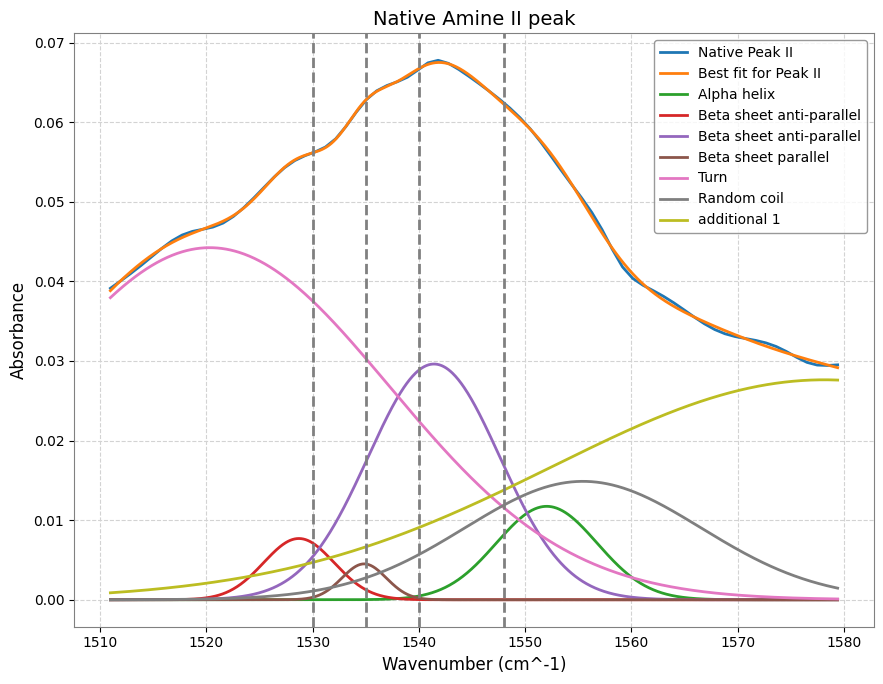

In [52]:
# Plot the results for Peak II
plt.figure(figsize=(9, 7))
plt.plot(x_data_II, y_data_II, label='Native Peak II')
amine_II_linespace = np.linspace(x_data_II.min(), x_data_II.max(), 1000)
plt.plot(amine_II_linespace, multi_gaussian(amine_II_linespace, *best_fit_params_II), label='Best fit for Peak II')
# Plot the individual components (gaussians)
for i in range(0, len(best_fit_params_II), 3):
    plt.plot(amine_II_linespace, best_fit_params_II[i] * np.exp(-((amine_II_linespace - best_fit_params_II[i+1]) ** 2) / (2 * best_fit_params_II[i+2] ** 2)), label=amine_I_components[i//3])

# Add vertical dotted lines for the theoretical peaks
for peak in amine_II_teo_peaks:
    plt.axvline(peak, color='gray', linestyle='--')
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance')
plt.title('Native Amine II peak')
plt.legend()
plt.show()

In [53]:
# put the parameters in a table
amine_II_components_table = pd.DataFrame(columns=['Media', 'Errore Media', 'sigma', 'Errore Sigma', 'ampiezza', 'Errore Ampiezza'])
for i in range(0, len(best_fit_params_II), 3):
    amine_II_components_table = pd.concat([amine_II_components_table, pd.DataFrame({'Media': [best_fit_params_II[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_II[i+1][i+1])], 'sigma': [best_fit_params_II[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_II[i+2][i+2])], 'ampiezza': [best_fit_params_II[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_II[i][i])]})], ignore_index=True)

amine_II_components_table.head(10)

C:\Users\giova\AppData\Local\Temp\ipykernel_33608\3667115910.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  amine_II_components_table = pd.concat([amine_II_components_table, pd.DataFrame({'Media': [best_fit_params_II[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_II[i+1][i+1])], 'sigma': [best_fit_params_II[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_II[i+2][i+2])], 'ampiezza': [best_fit_params_II[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_II[i][i])]})], ignore_index=True)


,Media,Errore Media,sigma,Errore Sigma,ampiezza,Errore Ampiezza
0,1552.025308,3.006575,4.743898,3.462741,0.011737,0.053961
1,1528.696929,0.909340,3.311004,0.802277,0.007694,0.006154
2,1541.416443,6.037415,6.192582,2.525216,0.029618,0.105749
3,1534.839466,0.306992,2.089054,0.579009,0.004506,0.003627
4,1520.308083,142.693408,16.899518,58.326902,0.044238,0.449313
5,1555.439057,112.814202,11.125770,171.844407,0.014877,0.832234
6,1578.153996,637.437210,25.562885,791.006788,0.027637,0.195119


In [14]:
mean_params_II = [1548, 1530, 1540, 1535, 1515, 1563]  # Mean values
sigmas_II = np.linspace(1, 20, 30) # Sigma range
amine_II_components = ['Alpha helix', 'Beta sheet anti-parallel', 'Beta sheet parallel', 'Random coil', 'additional 1', 'additional 2']

# Get initial amplitudes for amine II denatured
amplitudes_II_denatured = []
correction_factor = 0.9
for mean in mean_params_II:
    # evaluate the data where the mean is located
    data_mean_index = data_amine_II_denatured['Wavenumber (cm^-1)'].sub(mean).abs().idxmin()
    # get the amplitude of the data at the mean
    amplitude = data_amine_II_denatured['Absorbance (AU)'][data_mean_index]
    # correct the amplitude and append it to the list
    amplitudes_II_denatured.append(amplitude * correction_factor)

# Create the grid of parameters for denatured
param_II_grid_denatured = []
for sigma in sigmas_II:
    params = []
    for i,amplitude in enumerate(amplitudes_II_denatured):
        params.append(amplitude)
        params.append(mean_params_II[i])
        params.append(sigma)
    param_II_grid_denatured.append(params)

In [15]:
# Fit the denatured Amine II peak

X_den_II = data_amine_II_denatured['Wavenumber (cm^-1)']
Y_den_II = data_amine_II_denatured['Absorbance (AU)']

best_mse = float('inf')
best_fit_cov_den_II = None
# Perform the grid search for Peak II
for init_params_II in param_II_grid_denatured:
    try:
        fit_II_params, pcov_amine_II_denaturated = fit_multi_gaussian(X_den_II, Y_den_II, init_params_II)
    except:
        continue
    # If a gaussian has negative amplitude, skip the iteration
    if any(fit_II_params[i] < 0 for i in range(0, len(fit_II_params), 3)):
        continue
    residuals_II = Y_den_II - multi_gaussian(X_den_II, *fit_II_params)
    mse_II = np.mean(residuals_II**2)
    print(mse_II)
    if mse_II < best_mse:
        best_mse = mse_II
        best_fit_params_den_II = fit_II_params
        print('ciao')
        print(pcov_amine_II_denaturated)
        best_fit_cov_den_II = pcov_amine_II_denaturated

1.7375064336409355e-07
ciao
[[ 4.04329590e-06 -1.08503433e-04  4.18920410e-04 -1.40472551e-05
  -8.07759900e-04 -1.35462841e-03 -4.91702214e-05  7.34669265e-04
  -2.96385157e-03  2.33977709e-05  1.27929579e-03  7.10255070e-03
  -2.69746047e-05 -5.92904933e-03 -2.13452085e-03 -1.68905839e-05
   5.58885337e-03 -1.42257895e-03]
 [-1.08503433e-04  1.40661444e-02 -1.22102088e-02  3.68450080e-04
   2.28450603e-02  3.69863695e-02  1.32638673e-03 -8.19584369e-03
   7.89177037e-02 -5.59012740e-04 -2.53259874e-02 -1.79237509e-01
   6.88500591e-04  1.51620968e-01  5.49960482e-02  3.70147636e-04
  -1.03656487e-01  1.94846885e-02]
 [ 4.18920410e-04 -1.22102088e-02  5.81802270e-02 -1.28424827e-03
  -7.28912103e-02 -1.22261742e-01 -4.63692608e-03  5.83626507e-02
  -2.88798446e-01  2.19322048e-03  1.23666896e-01  6.61106943e-01
  -2.50787424e-03 -5.52394564e-01 -1.99722537e-01 -1.56194632e-03
   5.16977534e-01 -1.32003247e-01]
 [-1.40472551e-05  3.68450080e-04 -1.28424827e-03  1.22787371e-04
   6.0255

C:\Users\giova\AppData\Local\Temp\ipykernel_56720\621749507.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(multi_gaussian, x_data, y_data, p0=initial_params)


1.1500436636103432e-06
5.795851830306734e-07


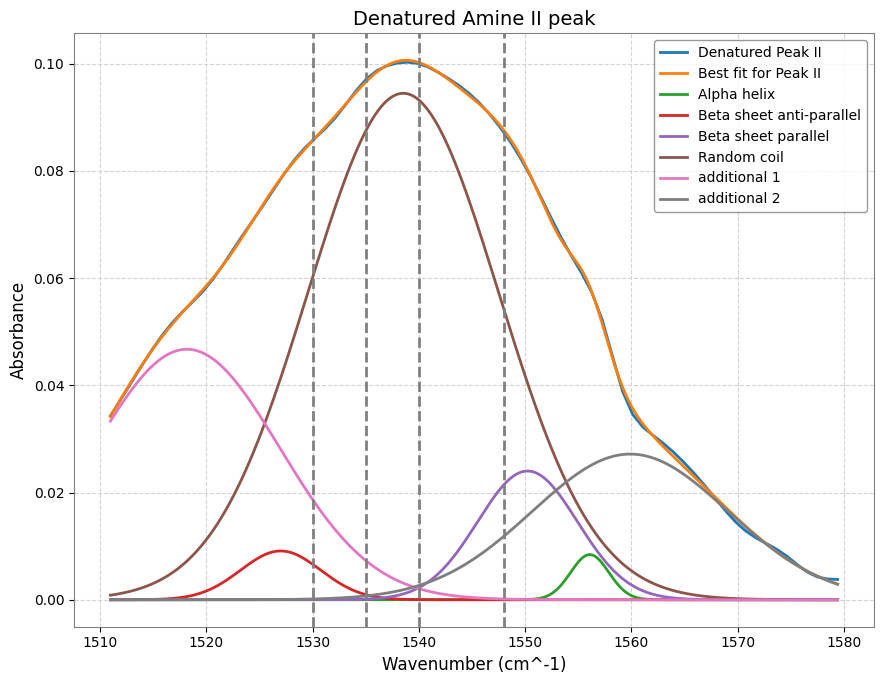

In [16]:
# Plot the results for Peak II
plt.figure(figsize=(9, 7))
plt.plot(X_den_II, Y_den_II, label='Denatured Peak II')
amine_II_linespace = np.linspace(X_den_II.min(), X_den_II.max(), 1000)
plt.plot(amine_II_linespace, multi_gaussian(amine_II_linespace, *best_fit_params_den_II), label='Best fit for Peak II')
# Plot the individual components (gaussians)
for i in range(0, len(best_fit_params_den_II), 3):
    plt.plot(amine_II_linespace, best_fit_params_den_II[i] * np.exp(-((amine_II_linespace - best_fit_params_den_II[i+1]) ** 2) / (2 * best_fit_params_den_II[i+2] ** 2)), label=amine_II_components[i//3])

# Add vertical dotted lines for the theoretical peaks
for peak in amine_II_teo_peaks:
    plt.axvline(peak, color='gray', linestyle='--')

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance')
plt.title('Denatured Amine II peak')
plt.legend()
plt.show()

In [18]:
# put the parameters in a table
amine_II_components_table = pd.DataFrame(columns=['Media', 'Errore Media', 'sigma', 'Errore Sigma', 'ampiezza', 'Errore Ampiezza'])
for i in range(0, len(best_fit_params_den_II), 3):
    amine_II_components_table = pd.concat([amine_II_components_table, pd.DataFrame({'Media': [best_fit_params_den_II[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_den_II[i+1][i+1])], 'sigma': [best_fit_params_den_II[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_den_II[i+2][i+2])], 'ampiezza': [best_fit_params_den_II[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_den_II[i][i])]})], ignore_index=True)

amine_II_components_table.head(10)

C:\Users\giova\AppData\Local\Temp\ipykernel_56720\910983536.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  amine_II_components_table = pd.concat([amine_II_components_table, pd.DataFrame({'Media': [best_fit_params_den_II[i+1]], 'Errore Media': [np.sqrt(best_fit_cov_den_II[i+1][i+1])], 'sigma': [best_fit_params_den_II[i+2]], 'Errore Sigma': [np.sqrt(best_fit_cov_den_II[i+2][i+2])], 'ampiezza': [best_fit_params_den_II[i]], 'Errore Ampiezza': [np.sqrt(best_fit_cov_den_II[i][i])]})], ignore_index=True)


,Media,Errore Media,sigma,Errore Sigma,ampiezza,Errore Ampiezza
0,1556.079105,0.118611,1.796496,0.241203,0.008429,0.002011
1,1526.981468,0.729779,3.773615,1.243267,0.009102,0.011079
2,1550.223256,0.705450,4.700619,1.694179,0.024018,0.030971
3,1538.523012,0.888796,8.979233,4.815041,0.094498,0.015945
4,1518.152018,4.180597,8.746381,1.735058,0.046743,0.018531
5,1559.888697,4.362692,9.228589,1.234557,0.027179,0.012330


In [28]:
# Calcola area gaussiane e arrore
def area_gaussian(amp, err_amp, sigma, err_sigma):
    area = amp * sigma * np.sqrt(2 * np.pi)
    errore = np.sqrt((err_amp * sigma * np.sqrt(2 * np.pi))**2 + (amp * err_sigma * np.sqrt(2 * np.pi))**2)
    return area, errore


amp = 0.094
err_amp = 0.016
sigma = 9
err_sigma = 4.82

area, errore = area_gaussian(amp, err_amp, sigma, err_sigma)
print(f'Area: {area} +- {errore}')

Area: 2.1206075203378263 +- 1.1916835778486428


In [25]:
#Area1: 0.0661749864502584 +- 0.05215955557717837
#Area2: 0.466232859081366 +- 1.6580485651626087

area_12 = 0.0661749864502584 + 0.466232859081366
err_area_12 = np.sqrt(0.05215955557717837**2 + 1.6580485651626087**2)
print(f'Area1+Area2: {area_12} +- {err_area_12}')

Area1+Area2: 0.5324078455316245 +- 1.6588687903736674


In [29]:
#Area: 2.1206075203378263 +- 1.1916835778486428

half_area = area_12 / 2
err_half_area = err_area_12 / 2

print(f'Half Area: {half_area} +- {err_half_area}')

Half Area: 0.26620392276581223 +- 0.8294343951868337
